# Seminar "WaveNet inference" 🌊


The purpose of this seminar is to immerse you in WaveNet architecture. In the lecture we discussed in detail WaveNet architecture, so you can easily write an autoregressive inference function.

<img src="https://www.researchgate.net/profile/Mark-Hasegawa-Johnson/publication/311106829/figure/fig3/AS:433958858039299@1480475262377/The-caching-scheme-for-efficient-generation-Due-to-dilated-convolutions-the-size-of-the.png" alt="Drawing" style="width: 60%;"/>

In [17]:
from IPython.display import Audio
from matplotlib import pyplot as plt
from tqdm import tqdm
import dataclasses
%matplotlib inline

from scipy.signal import lfilter
from queue import Queue

import soundfile as sf
import numpy as np
import librosa

import torch
import torch.nn as nn
from torch.nn import functional as F

## DSP utils 

"D" in "Deep Learning" stands for data and "e" for "engineering" 🙃, so we need to implement some basic data preprocessing functions.

## Pre-emphasis

Pre-emphasis filter:

$P(x) = x - \alpha * x^{-1}$, where $x^{-1}$ is $x$ shifted back to 1 time sample

De-emphasis filter:

$x = P(x) + \alpha * x^{-1}$

<img src="https://speechprocessingbook.aalto.fi/_images/149888832.png" width="100%">
<img src="https://speechprocessingbook.aalto.fi/_images/149888831.png" width="100%">

##  Mu-law

Mu encoding: 

$$F(x) = sgn(x) \dfrac{\ln(1 + \mu |x|)}{\ln(1 + \mu)}, \quad -1 \leq x \leq 1$$

$$F(x)_{discrete} = \Bigl\lfloor \frac{1}{2} (F(x) + 1) \mu + 0.5 \Bigr\rfloor$$ 

$$ \mu = 2^{bits} - 1, x \in (-1, 1)$$

Mu decoding: 

$$F^{-1}(x) = \frac{2}{\mu} F(x)_{discrete} - 1$$

$$x = sgn(F^{-1}(x)) \frac{(1 + \mu) ^ {|F^{-1}(x)|} - 1}{\mu}$$

In [30]:
def plot_spectrogram(spectrogram):
    fig, ax = plt.subplots(figsize=(16, 5))
    im = ax.imshow(spectrogram, aspect="auto", origin="lower",
                   interpolation='none')
    plt.colorbar(im, ax=ax)

    fig.canvas.draw()
    plt.show()

    return fig

In [58]:
class AudioProcessor:
    MAX_WAV_VALUE = 32768.0

    def __init__(self):
        num_frequencies = 1025
        self.sample_rate = 24000
        self.window_size = int(self.sample_rate * 0.05)
        self.window_step = self.window_size // 4
        self.n_fft = (num_frequencies - 1) * 2
        self.preemphasis_coef = 0.97
        self.min_frequency = 50
        self.max_frequency = 12000
        self.num_mel_bins = 80
        self.ref_level_db = 20
        self.min_level_db = -100
        
        self.min_level = np.exp(self.min_level_db / 20 * np.log(10))
        
    def load_wav(self, path):
        wav, sr = sf.read(path, dtype=np.float32)

        assert sr == self.sample_rate
        return wav

    def pre_emphasis(self, x):
        l = [x[0]]
        l.extend(x[1:] - x[:-1] * self.preemphasis_coef )
        return np.array(l)

    def de_emphasis(self, x):
        l = [x[0]]
        for el in x[1:]:
            l.append(el + l[-1] * self.preemphasis_coef)
        return np.array(l)
    
    def amp_to_db(self, x):
        x = np.maximum(self.min_level, x)
        return 20 * np.log10(x) - self.ref_level_db

    def mu_law_encode(self, x, mu=255):
        x_mu = np.sign(x) * np.log(1 + mu * np.abs(x)) / np.log(mu + 1)
        x_mu = np.floor((x_mu + 1) / 2 * mu + 0.5)
        return x_mu

    def mu_law_decode(self, x_mu, mu=255):
        x = ((x_mu) / mu) * 2 - 1.0
        x = np.sign(x) * (np.exp(np.abs(x) * np.log(mu + 1)) - 1.0) / mu
        return x

ap = AudioProcessor()

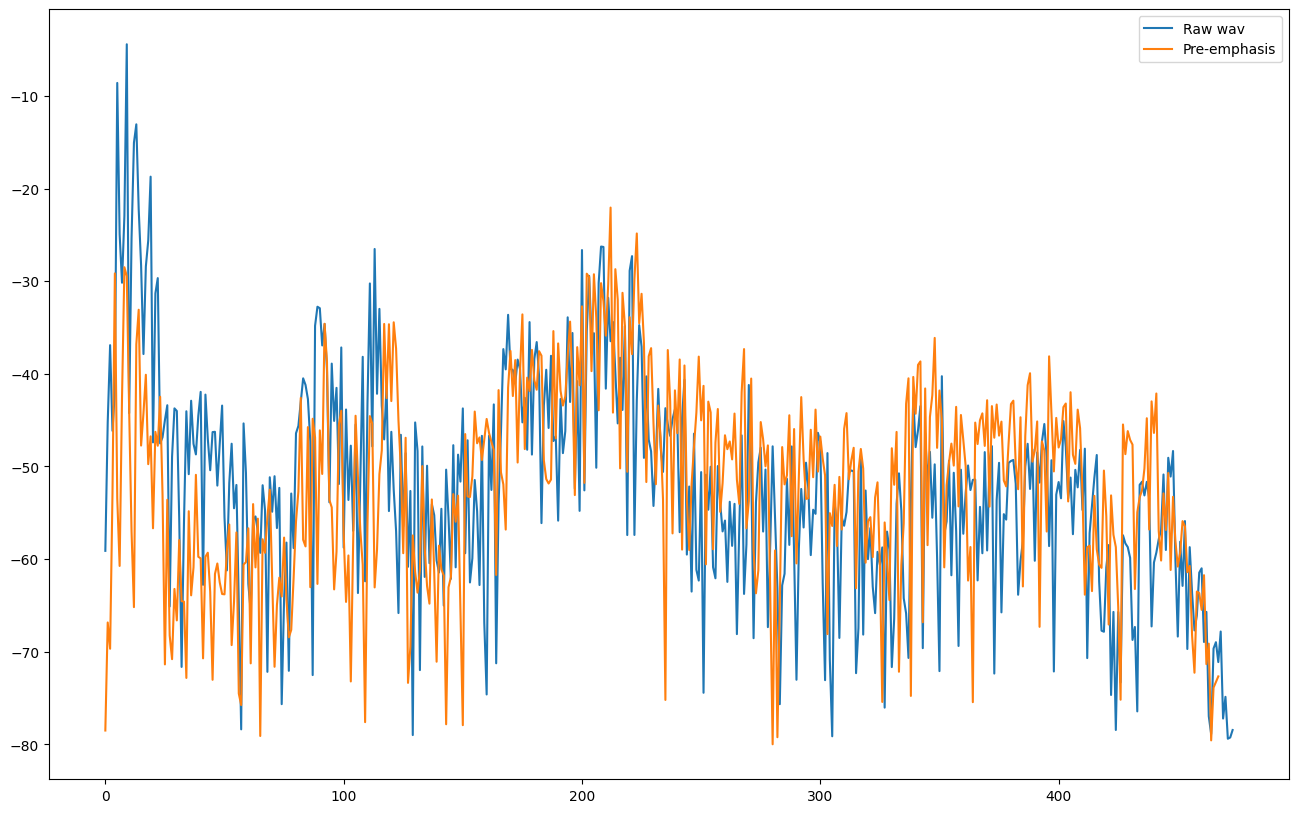

In [46]:
from scipy.fft import fft
x = ap.load_wav('./samples/00000.wav')
x_pre = ap.pre_emphasis(x)


window_size = 2000
start = 80000
window = librosa.core.spectrum.get_window('hann', window_size, fftbins=True)

x_stft = np.real(fft(x[start:start + window_size] * window))
x_stft = ap.amp_to_db(x_stft)
x_stft = x_stft[:len(x_stft)//2]
x_stft = x_stft[x_stft > -80]

x_stft_pre = np.real(fft(x_pre[start:start + window_size] * window))
x_stft_pre = ap.amp_to_db(x_stft_pre)
x_stft_pre = x_stft_pre[:len(x_stft_pre)//2]
x_stft_pre = x_stft_pre[x_stft_pre > -80]


plt.figure(figsize= (16, 10))
plt.plot(x_stft, label = 'Raw wav')
plt.plot(x_stft_pre, label = 'Pre-emphasis')
plt.legend()
plt.show()

/Users/19535739/codes/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: Pass y=[0.0000000e+00 3.0517578e-05 0.0000000e+00 ... 3.9672852e-04 8.2397461e-04
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  # Remove the CWD from sys.path while we load stuff.
/Users/19535739/codes/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: Pass y=[ 0.0000000e+00  3.0517578e-05 -2.9602052e-05 ...  2.7832031e-04
  4.3914793e-04 -7.9925539e-04] as keyword args. From version 0.10 passing these as positional arguments will result in an error


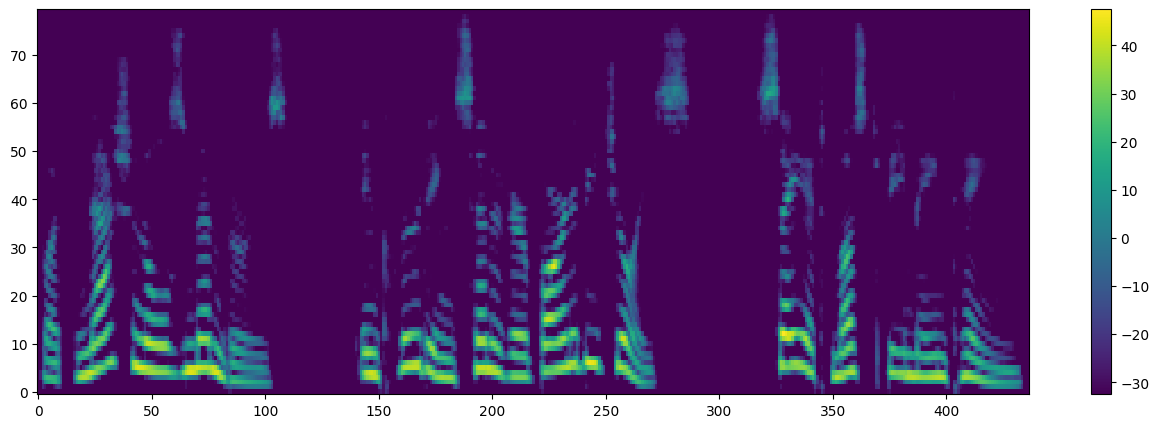

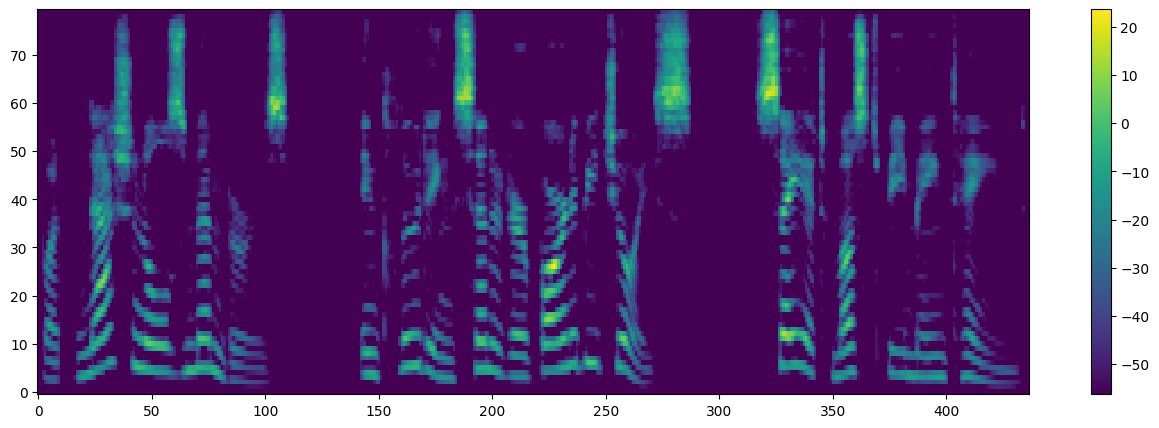

In [47]:
# Raw mel spec
x = ap.load_wav('./samples/00000.wav')
mel = librosa.amplitude_to_db(
    librosa.feature.melspectrogram(
        x, 
        n_mels=ap.num_mel_bins,
        sr=ap.sample_rate,
        n_fft=ap.n_fft, 
        hop_length=ap.window_step, 
        win_length=ap.window_size
    )
)

# Mel spec with preemphasis
mel_pre = librosa.amplitude_to_db(
    librosa.feature.melspectrogram(
        ap.pre_emphasis(x), 
        n_mels=ap.num_mel_bins,
        sr=ap.sample_rate,
        n_fft=ap.n_fft, 
        hop_length=ap.window_step, 
        win_length=ap.window_size
    )
)


plot_spectrogram(mel)
plt.show()

plot_spectrogram(mel_pre)
plt.show()

In [59]:
# check that all tests are passed

x = ap.load_wav('./samples/00000.wav')

assert np.abs(ap.de_emphasis(ap.pre_emphasis(x)) - x).max() < 1e-6

assert ap.mu_law_encode(-1.0) == 0
assert ap.mu_law_encode(0.0) == 128
assert ap.mu_law_encode(0.5) == 239
assert ap.mu_law_encode(1.0) == 255
for i in range(256):
    assert ap.mu_law_encode(ap.mu_law_decode(i)) == i

## WaveNet

<img src="./deepvoice.png" width="100%">
<img src="./wavenet.png" width="100%">

In [32]:
class CausalConv1d(nn.Conv1d):
    def __init__(self, train=True, *args, **kwargs):
        super(CausalConv1d, self).__init__(*args, **kwargs)
        self.train = train
        self.padding = ((self.kernel_size[0] - 1) * self.dilation[0],)

    def forward(self, x):
        if self.train:
            x = super(CausalConv1d, self).forward(x)
            return x[:, :, :-self.padding[0]]
        else:
            padding_train = self.padding
            dilated_kernel_size = (self.kernel_size[0] - 1) * self.dilation[0]
            
            if x.size(2) < (dilated_kernel_size + 1):
                self.padding = (dilated_kernel_size - x.size(2) + 1, )
            else:
                assert x.size(2) == dilated_kernel_size + 1
                self.padding = (0, )
                
            x = super(CausalConv1d, self).forward(x)
            
            if self.padding[0] != 0:
                x = x[:, :, :-self.padding[0]]
            assert x.size(2) == 1
            return x


class WaveNet(nn.Module):
    """WaveNet architecture with local conditioning

    https://arxiv.org/pdf/1609.03499.pdf - original paper
    https://arxiv.org/pdf/1702.07825.pdf - appending A for more details
    
    But given implementation has following differences:
    1. tanh is not applied to input embedding
    2. vector is scaled (multiplied 0.5 ** 0.5) between blocks
    3. GRU is used for processing mel spectrogram
    4. GRU output is nearest neighbour apsampled hop_size times
    5. each block has own conditioning projection

    Args:
        num_channels       (int): size of modelled categorical distribution
        residual_channels  (int): hidden vector size
        gate_channels      (int): gate block dimension
        skip_channels      (int): skip-vector size
        pre_channels       (int): dimension before the last layer
        dilation_cycles    (int): number of dilation cycles
        dilation_depth     (int): blocks number in dilation cycle
        condition_channels (int): number of mel filters
        hop_size           (int): STFT hop size
    """

    def __init__(self,
                 num_channels,
                 residual_channels,
                 gate_channels,
                 skip_channels,
                 pre_channels,
                 dilation_cycles,
                 dilation_depth,
                 condition_channels,
                 hop_size,
                 train=True):
        super(WaveNet, self).__init__()
        
        self.kernel_size = 2
        self.dilations = np.array([
            2 ** (i % dilation_depth) 
            for i in range(dilation_cycles * dilation_depth)
        ])
        
        self.num_channels = num_channels
        self.residual_channels = residual_channels
        self.gate_channels = gate_channels
        self.skip_channels = skip_channels
        self.pre_channels = pre_channels
        self.hop_size = hop_size
        
        self.condition_net = nn.GRU(
            input_size=condition_channels,
            hidden_size=condition_channels // 2,
            num_layers=2,
            batch_first=True,
            bidirectional=True)
        
        self.conv_input = nn.Conv1d(
            in_channels=num_channels,
            out_channels=residual_channels,
            kernel_size=1)

        self.blocks_conv_filter = nn.ModuleList([
            CausalConv1d(
                in_channels=residual_channels,
                out_channels=gate_channels,
                kernel_size=2,
                dilation=d,
                train=train
            ) for d in self.dilations])

        self.blocks_conv_gate = nn.ModuleList([
            CausalConv1d(
                in_channels=residual_channels,
                out_channels=gate_channels,
                kernel_size=2,
                dilation=d,
                train=train
            ) for d in self.dilations])
        
        self.blocks_conv_residual = nn.ModuleList([
            nn.Conv1d(
                in_channels=gate_channels,
                out_channels=residual_channels,
                kernel_size=1
            ) for _ in range(len(self.dilations) - 1)])
        
        self.blocks_conv_skip = nn.ModuleList([
            nn.Conv1d(
                in_channels=gate_channels,
                out_channels=skip_channels,
                kernel_size=1
            ) for _ in range(len(self.dilations))])
        
        self.blocks_conv_cond = nn.ModuleList([
            nn.Conv1d(
                in_channels=condition_channels,
                out_channels=gate_channels * 2,
                kernel_size=1
            ) for _ in range(len(self.dilations))])
        
        self.conv_out_1 = nn.Conv1d(
            in_channels=skip_channels,
            out_channels=pre_channels,
            kernel_size=1)
        self.conv_out_2 = nn.Conv1d(
            in_channels=pre_channels,
            out_channels=num_channels,
            kernel_size=1)

    def forward(self, x, c):
        """
        Args:
            x (FloatTensor): continuous audio signal [B x K x T]
            c (FloatTensor): local condition features [B x L x C],
                where L = T // 300

        Returns:
            FloatTensor: output [B x out_channels x T]
        """
        
        x = self.conv_input(x)
        c, _ = self.condition_net(c)
        c = c.transpose(1, 2)

        c = nn.functional.interpolate(c,
            scale_factor=self.hop_size,
            mode='nearest')

        assert c.size(2) == x.size(2)

        x_acc = 0
        for b in range(len(self.dilations)):
            x_filter = self.blocks_conv_filter[b](x)
            x_gate = self.blocks_conv_gate[b](x)

            cond = self.blocks_conv_cond[b](c)
            c_filter, c_gate = cond.chunk(chunks=2, dim=1)
            x_filter += c_filter
            x_gate += c_gate

            x_hidden = torch.tanh(x_filter) * torch.sigmoid(x_gate)

            x_skip = self.blocks_conv_skip[b](x_hidden)
            x_acc = x_acc + x_skip

            if b < len(self.dilations) - 1:
                x_residual = self.blocks_conv_residual[b](x_hidden)
                x = x + x_residual

            x = x * 0.5 ** 0.5
            

        x = self.conv_out_1(torch.relu(x_acc))
        x = self.conv_out_2(torch.relu(x))

        return x

In [33]:
model = WaveNet(
    num_channels=256,
    residual_channels=64,
    gate_channels=64,
    skip_channels=128,
    pre_channels=256,
    dilation_cycles=4,
    dilation_depth=10,
    condition_channels=80,
    hop_size=300)
model.load_state_dict(torch.load('./state_dict.pth'))

<All keys matched successfully>

In [35]:
def one_hot(x, num_channels):
    x_o = torch.FloatTensor(x.shape[0], num_channels, x.shape[1])
    x_o.zero_().scatter_(1, x.unsqueeze(1), 1)
    return x_o

def calc_loss(model, x, c):
    x_o = one_hot(x, model.num_channels)
    y = model.forward(x_o, c).transpose(1, 2)

    loss = nn.functional.cross_entropy(
        y[:, :-1].contiguous().view(-1, y.shape[-1]),
        x[:, 1:].contiguous().view(-1))
    
    return loss

with torch.no_grad():
    x = ap.load_wav('./samples/00000.wav')
    c = np.load('./samples/00000.npy')
    
    # cut off to be a multiple of the window step
    c = c[:len(x) // ap.window_step]
    x = x[:len(c) * ap.window_step]
    
    print (c.shape, x.shape)
    
    # apply mu-law encoding
    x = ap.mu_law_encode(x)

    x = torch.LongTensor(x)
    c = torch.FloatTensor(c)

    loss = calc_loss(model, x.unsqueeze(0), c.unsqueeze(0)).item()

assert np.allclose(loss, 1.7863293886184692)

(436, 80) (130800,)


# WaveNet Inference 

**Important note**: as you can see from the code, we calculate spectrograms passing them through the pre-emphasis filter. It so happened (obviously by mistake) that although WaveNet learned with such spectrograms, but the audio signal for was not passed through the pre-emphasis filter. So you **do not need** to pass WaveNet output through de-emphassis filter.

In [36]:
from collections import deque
class DilatedDeque:
    def __init__(self, dilation, kernel):
        self.dilation = dilation
        self.kernel = kernel
        self.max_len = (kernel - 1) * dilation + 1
        
        self.queue = torch.Tensor([])
        self.start = 0
    
    def update_queue(self, state):
        self.queue = torch.cat([self.queue, state], dim=-1)

        if self.queue.size(2) > self.max_len:
            self.queue = self.queue[:, :, 1:]
    
    def get_queue(self):
        return self.queue

In [37]:
from abc import ABC

class Storage(ABC):
    pass
storage = Storage()

In [38]:
model = WaveNet(
    num_channels=256,
    residual_channels=64,
    gate_channels=64,
    skip_channels=128,
    pre_channels=256,
    dilation_cycles=4,
    dilation_depth=10,
    condition_channels=80,
    hop_size=300,
    train=False)
model.load_state_dict(torch.load('./state_dict.pth'))

<All keys matched successfully>

In [ ]:
def infer(model, mel):
    with torch.no_grad():
        mel = torch.FloatTensor(mel).unsqueeze(0)

        mel, _ = model.condition_net(mel)

        mel = mel.transpose(1, 2)

        mel = nn.functional.interpolate(
            mel,
            scale_factor=model.hop_size,
            mode='nearest'
        )

        for block in [
            "blocks_conv_filter_queue", 
            "blocks_conv_gate_queue"
        ]:
            for b in range(len(model.dilations)):
                setattr(storage, block + f"_{b}", DilatedDeque(model.dilations[b], 2))

        for b in range(len(model.dilations)):
            setattr(storage, f"blocks_conv_cond_{b}", model.blocks_conv_cond[b](mel))

        generated = torch.LongTensor([128]).unsqueeze(0)
        for i in tqdm(range(mel.size(2))):
            x = model.conv_input(one_hot(generated[:, -1:], model.num_channels))
            x_acc = torch.zeros(1, 128, 1)

            for b in range(len(model.dilations)):
                # ---------------------------------------------------------------------------
                # Filter queue
                filter_queue_input = getattr(storage, f"blocks_conv_filter_queue_{b}")

                filter_queue_input.update_queue(x)
                x_filter = model.blocks_conv_filter[b](filter_queue_input.get_queue())
                # ---------------------------------------------------------------------------

                # ---------------------------------------------------------------------------
                # Gate queue
                gate_queue_input = getattr(storage, f"blocks_conv_gate_queue_{b}")

                gate_queue_input.update_queue(x)
                x_gate = model.blocks_conv_gate[b](gate_queue_input.get_queue())
                # ---------------------------------------------------------------------------

                cond = getattr(storage, f"blocks_conv_cond_{b}")[:, :, i].unsqueeze(-1)
                c_filter, c_gate = cond.chunk(chunks=2, dim=1)
                x_filter += c_filter
                x_gate += c_gate

                x_hidden = torch.tanh(x_filter) * torch.sigmoid(x_gate)
                x_skip = model.blocks_conv_skip[b](x_hidden)
                x_acc = x_acc + x_skip

                if b < len(model.dilations) - 1:
                    x_residual = model.blocks_conv_residual[b](x_hidden)
                    x = x + x_residual

                x = (x * 0.5 ** 0.5)

            x = model.conv_out_1(torch.relu(x_acc))
            x = model.conv_out_2(torch.relu(x))

            prob = F.softmax(x, dim=1)
            np_prob = prob.view(-1).data.numpy()

            x = np.random.choice(model.num_channels, p=np_prob)
            x = torch.LongTensor([x]).unsqueeze(0)

            generated = torch.cat((generated, x), dim=-1)
    return generated 
    


x = ap.load_wav('./samples/00000.wav')
x_gen = ap.mu_law_decode(infer(model, np.load('./samples/00000.npy')))

display(Audio(x, rate=ap.sample_rate))
display(Audio(x_gen, rate=ap.sample_rate))

In [38]:
sf.write('./samples/gen.wav', x_gen.reshape(-1, ), ap.sample_rate)

In [44]:
wav, sr = sf.read('./samples/gen.wav')
display(Audio(wav.reshape(-1, ), rate=ap.sample_rate))